# AICE Professioanl 대비 - 텍스트 처리(NLP) 실습
[Korean Hate Speech Dataset]
- 소개: 고려대학교 NLP 연구실에서 공개한 혐오 발언 탐지 데이터셋으로, 온라인 댓글과 그에 대한 혐오 표현 여부를 포함하고 있습니다.
- 링크: Korean Hate Speech Dataset
- 특징: 온라인 커뮤니티의 댓글을 기반으로 하며, 혐오 발언, 욕설, 일반 발언으로 분류되어 있습니다.

## NLP 순서
- 텍스트 데이터 전처리
- 한글 형태소 분석(Okt, Mecab 등)
- Tokenizer(Word Dictionary 생성)
- Texts to Sequences
- Embedding(단어 밀집벡터 표현)
- LSTM 모델링


## 모델링 순서

**1. 데이터 로드 및 공통 전처리**
- train_data, test_data Load
- Preprocess -> 라벨인코딩, 결측치 제거 및 텍스트 정제(한글 외 문자 제거)

**2. 머신러닝**
- 2.1 머신러닝 모델링
- 2.2 머신러닝 모델 평가 및 예측

**3. 딥러닝 모델링**
- 3.1 전처리: 1)형태소 분석(Mecab), 2)단어 인덱스화(Tokenizer), 3)Padding 처리
- 3.2 딥러닝 모델링
- 3.3 딥러닝 모델 평가 및 예측



# 1. 데이터 로드 및 전처리
## 데이터 로드
Korean Hate Speech Dataset을 GitHub에서 다운로드하고 로드합니다.

In [ ]:
!git clone https://github.com/kocohub/korean-hate-speech.git

Cloning into 'korean-hate-speech'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 112 (delta 4), reused 0 (delta 0), pack-reused 103 (from 1)
Receiving objects: 100% (112/112), 93.18 MiB | 14.26 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (20/20), done.


In [ ]:
# 필요한 라이브러리 임포트
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from tqdm import tqdm
import tensorflow as tf


# 데이터 로드
train_data = pd.read_csv('korean-hate-speech/labeled/train.tsv', sep='\t')
test_data = pd.read_csv('korean-hate-speech/labeled/dev.tsv', sep='\t')


## 데이터 확인
데이터의 구조와 결측값 여부를 확인합니다.

In [ ]:
# 데이터 확인
print(train_data.head())
print(train_data.isnull().sum())


                                            comments  contain_gender_bias  \
0  (현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...                False   
1  ....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...                False   
2  ...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...                False   
3                 1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데                False   
4  1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...                 True   

     bias  hate  
0  others  hate  
1    none  none  
2    none  hate  
3    none  none  
4  gender  hate  
comments               0
contain_gender_bias    0
bias                   0
hate                   0
dtype: int64


In [ ]:
train_data.columns

Index(['comments', 'contain_gender_bias', 'bias', 'hate'], dtype='object')

In [ ]:
# 데이터 확인
print(test_data.head())
print(test_data.isnull().sum())


                                            comments  contain_gender_bias  \
0                        송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.                False   
1                                            지현우 나쁜놈                False   
2         알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라                False   
3                                   설마 ㅈ 현정 작가 아니지??                 True   
4  이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...                False   

     bias       hate  
0    none       none  
1    none  offensive  
2    none       hate  
3  gender       hate  
4    none  offensive  
comments               0
contain_gender_bias    0
bias                   0
hate                   0
dtype: int64


In [ ]:
test_data

,comments,contain_gender_bias,bias,hate
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,False,none,none
1,지현우 나쁜놈,False,none,offensive
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,False,none,hate
3,설마 ㅈ 현정 작가 아니지??,True,gender,hate
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,False,none,offensive
...,...,...,...,...
466,지현우 범죄 저지르지 않았나요?,False,none,offensive
467,여자인생 망칠 일 있나 ㅋㅋ,True,gender,hate
468,근데 전라도에서 사고가 났는데 굳이 서울까지 와서 병원에 가느 이유는?,False,others,offensive
469,"할매젖x, 뱃살x, 몸매 s라인, 유륜은 적당해야됨(너무크거나 너무 작아도 x), ...",True,gender,hate


## 라벨 변경
라벨을 숫자로 인코딩합니다.

- hate: 혐오 발언 (2)
- offensive: 욕설 (1)
- none: 일반 발언 (0)

In [ ]:
# 레이블 인코딩
label_mapping = {'none': 0, 'offensive': 1, 'hate': 2}
train_data['label'] = train_data['hate'].map(label_mapping)
test_data['label'] = test_data['hate'].map(label_mapping)


In [ ]:
train_data

,comments,contain_gender_bias,bias,hate,label
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate,2
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none,0
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate,2
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",False,none,none,0
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate,2
...,...,...,...,...,...
7891,힘내세요~ 응원합니다!!,False,none,none,0
7892,힘내세요~~삼가 고인의 명복을 빕니다..,False,none,none,0
7893,힘내세용 ^^ 항상 응원합니닷 ^^ !,False,none,none,0
7894,힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...,False,none,none,0


## 텍스트 정제
한글 외의 문자들을 삭제하여 텍스트를 정제합니다.

In [ ]:
# 한글 외 문자 제거
train_data['comments'] = train_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
test_data['comments'] = test_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


# 2. 머신러닝
## 2.1 머신러닝 모델링

머신러닝 모델을 사용할 때:
TF-IDF와 같은 벡터화 기법을 사용하여 고정 길이의 입력 데이터를 생성합니다.

단어의 순서나 문맥 정보가 크게 중요하지 않을 때 효과적입니다.

### TF-IDF 벡터화
텍스트 데이터를 TF-IDF 벡터로 변환합니다.

In [ ]:
# TF-IDF 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 벡터라이저 생성
vectorizer = """입력하세요"""()
X_train_tfidf = vectorizer."""입력하세요"""(train_data['comments'])
X_test_tfidf = vectorizer."""입력하세요"""(test_data['comments'])

# 레이블 추출
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])


## 머신러닝 모델 학습
랜덤 포레스트 분류기를 사용하여 학습합니다.

In [ ]:
# 랜덤 포레스트 모델 학습
from sklearn.ensemble import RandomForestClassifier

rf_model = """입력하세요"""()
rf_model.fit(X_train_tfidf, y_train)


RandomForestClassifier()

## 2.2 머신러닝 모델 평가 및 예측
### 모델 평가
테스트 데이터를 사용하여 머신러닝 모델의 성능을 평가합니다.

In [ ]:
# 모델 평가
from sklearn.metrics import accuracy_score

y_pred_ml = rf_model.predict(X_test_tfidf)
accuracy_ml = """입력하세요"""(y_test, y_pred_ml)
print('머신러닝 모델 테스트 정확도: {:.4f}'.format(accuracy_ml))


머신러닝 모델 테스트 정확도: 0.4501


예측 함수 정의
새로운 문장에 대한 예측을 수행하는 함수를 정의합니다.

In [ ]:
# 예측 함수 정의
def ml_sentiment_predict(new_sentence):
    new_sentence = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", new_sentence)
    vector = vectorizer."""입력하세요"""([new_sentence])
    result = rf_model."""입력하세요"""(vector)
    labels = {0: '일반 발언', 1: '욕설', 2: '혐오 발언'}
    print(f"'{labels[result[0]]}'로 분류되었습니다.")


**예시 문장 예측**

In [ ]:
# 예시 문장 예측
ml_sentiment_predict('이 사람 정말 싫어요.')
ml_sentiment_predict('안녕하세요, 좋은 하루입니다.')


'일반 발언'로 분류되었습니다.
'일반 발언'로 분류되었습니다.




---



---



# 3. 딥러닝

## 3.1 딥러닝 전처리


## 형태소 분석 및 토큰화
Mecab 형태소 분석기를 사용하여 텍스트를 토큰화합니다.

Mecab 설치
Colab에서 Mecab을 사용하기 위해 설치합니다.

In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh

# # !curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91 (from 1)
Receiving objects: 100% (138/138), 1.72 MiB | 13.94 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Mecab-ko-for-Google-Colab/Mecab-ko-for-Google-Colab/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2024-09-16 13:23:23--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.142.25, 104.192.142.24, 104.192.142.26, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.142.25|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/m

## 형태소 분석기 임포트 및 토큰화

In [ ]:
# 형태소 분석기 임포트
from konlpy.tag import Mecab
mecab = Mecab()

# 토큰화 함수 정의
def mecab_morphs(doc):
    return mecab.morphs(doc)

# 토큰화 적용
train_data['tokenized'] = train_data['comments'].apply(mecab_morphs)
test_data['tokenized'] = test_data['comments'].apply(mecab_morphs)



In [ ]:
train_data

,comments,contain_gender_bias,bias,hate,label,tokenized
0,현재 호텔주인 심정 아 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 추모받네,False,others,hate,2,"[현재, 호텔, 주인, 심정, 아, 난, 마른, 하늘, 에, 날벼락, 맞, 고, 호..."
1,한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠ,False,none,none,0,"[한국, 적, 인, 미인, 의, 대표, 적, 인, 분, 너무나, 곱, 고, 아름다운..."
2,못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...,False,none,hate,2,"[못, 된, 넘, 들, 남, 의, 고통, 을, 즐겼, 던, 넘, 들, 이젠, 마땅,..."
3,화 어설펐는데 화 지나서부터는 갈수록 너무 재밌던데,False,none,none,0,"[화, 어설펐, 는데, 화, 지나, 서, 부터, 는, 갈수록, 너무, 재밌, 던데]"
4,사람 얼굴 손톱으로 긁은것은 인격살해이고 동영상이 몰카냐 메걸리안들 생각이 없노,True,gender,hate,2,"[사람, 얼굴, 손톱, 으로, 긁, 은, 것, 은, 인격, 살해, 이, 고, 동영상..."
...,...,...,...,...,...,...
7891,힘내세요 응원합니다,False,none,none,0,"[힘내, 세요, 응, 원합니다]"
7892,힘내세요삼가 고인의 명복을 빕니다,False,none,none,0,"[힘내, 세요, 삼가, 고인, 의, 명복, 을, 빕, 니다]"
7893,힘내세용 항상 응원합니닷,False,none,none,0,"[힘내, 세용, 항상, 응, 원합, 니, 닷]"
7894,힘내소연기로 답해요나도 살 인데 이런일 저런일 다 있더라구요인격을 믿습니다홨팅,False,none,none,0,"[힘, 내소, 연기, 로, 답, 해요, 나, 도, 살, 인데, 이런, 일, 저런, ..."


## 단어 인덱스화
딥러닝 모델을 사용할 때:
Tokenizer와 임베딩 레이어를 사용하여 단어의 순서와 문맥을 고려합니다.

복잡한 패턴과 의미를 학습하고자 할 때 적합합니다.

각 단어를 고유한 정수로 인코딩합니다.

In [ ]:
# 전체 단어 사전 구축
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = """입력하세요"""()
tokenizer.fit_on_texts(train_data['tokenized'])

# 텍스트를 시퀀스로 변환
X_train = tokenizer."""입력하세요"""(train_data['tokenized'])
X_test = tokenizer.texts_to_sequences(test_data['tokenized'])

# 레이블 추출
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])


## 패딩 처리
입력 시퀀스의 길이를 동일하게 맞추기 위해 패딩을 적용합니다.

In [ ]:
max(len(line) for line in X_train)

70

In [ ]:
# 패딩 처리
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max(len(line) for line in X_train)  # 최대 문장 길이 지정
X_train_padded = pad_sequences(X_train, maxlen=max_len)
X_test_padded = pad_sequences(X_test, maxlen=max_len)


## 3.2 딥러닝 모델링
###  모델 구성
임베딩 층과 LSTM 층을 활용하여 모델을 구성합니다.

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPool2D
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, SimpleRNN, GRU, Dropout, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

max_words = 35000  # 사전에 사용할 최대 단어 수
max_len = max(len(line) for line in X_train)       # 패딩 시퀀스의 최대 길이

embedding_dim = 128  # 임베딩 차원
lstm_units = 128     # LSTM 유닛 수

# 모델 구성
dl_model = Sequential()
dl_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))  # 단어 사전 크기, 임베딩 벡터 차원
dl_model.add(LSTM(lstm_units))  # LSTM 레이어
dl_model.add(Dense(3, activation='softmax'))  # 출력층

# 모델 컴파일
dl_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
dl_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 모델 학습
훈련 데이터를 사용하여 모델을 학습시킵니다.

In [ ]:
# 조기종료 콜백함수 정의(EarlyStopping)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# 체크포인트 저장(ModelCheckpoint)
checkpoint_path = 'tmp_checkpoint.keras'
cp = ModelCheckpoint(filepath = checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
# 모델 학습
history = dl_model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_split=0.2, verbose=1, callbacks=[es, cp])


Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - acc: 0.4603 - loss: 1.0355
Epoch 1: val_loss improved from inf to 0.93371, saving model to tmp_checkpoint.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 51s 481ms/step - acc: 0.4606 - loss: 1.0350 - val_acc: 0.5627 - val_loss: 0.9337
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - acc: 0.6525 - loss: 0.7772
Epoch 2: val_loss improved from 0.93371 to 0.89204, saving model to tmp_checkpoint.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 272ms/step - acc: 0.6526 - loss: 0.7769 - val_acc: 0.5614 - val_loss: 0.8920
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - acc: 0.8032 - loss: 0.5090
Epoch 3: val_loss did not improve from 0.89204
99/99 ━━━━━━━━━━━━━━━━━━━━ 39s 253ms/step - acc: 0.8033 - loss: 0.5089 - val_acc: 0.5551 - val_loss: 1.0692
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - acc: 0.8943 - loss: 0.2955
Epoch 4: val_loss did not improve from 0.89204
99/99 ━━━━━━━━━━━━━━━━━━━━ 40s 242ms/step - acc: 0.8942 - loss: 0.2955 - val_acc: 0.5785

In [ ]:
##모델 로드 웨이트
dl_model.load_weights(checkpoint_path)
##모델 저장
dl_model.save("NLP_mission_2.h5")

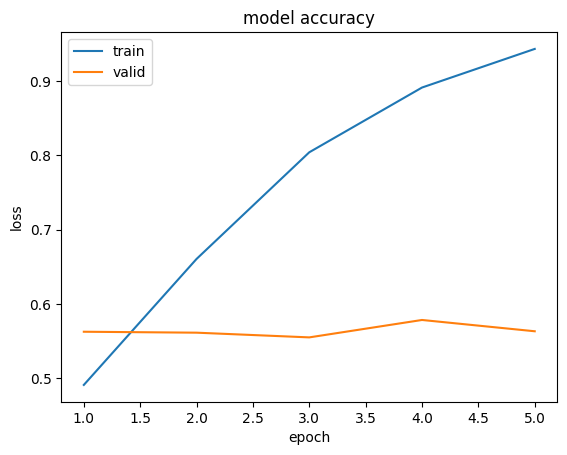

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], )
plt.show()

## 3.3 딥러닝 모델 평가 및 예측
###모델 평가
테스트 데이터를 사용하여 딥러닝 모델의 성능을 평가합니다.

In [ ]:
# 모델 평가
loss, accuracy = dl_model.evaluate(X_test_padded, y_test)
print('딥러닝 모델 테스트 정확도: {:.4f}'.format(accuracy))


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.5370 - loss: 0.9248
딥러닝 모델 테스트 정확도: 0.5584


## 예측 함수 정의
새로운 문장에 대한 예측을 수행하는 함수를 정의합니다.

In [ ]:
# 예측 함수 정의
def dl_sentiment_predict(new_sentence):
    new_sentence = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", new_sentence)
    new_sentence = mecab."""입력하세요"""(new_sentence)
    encoded = tokenizer."""입력하세요"""([new_sentence])
    pad_new = pad_sequences(encoded, maxlen=max_len)
    score = dl_model.predict(pad_new)
    labels = {0: '일반 발언', 1: '욕설', 2: '혐오 발언'}
    print(f"'{labels[np.argmax(score)]}'로 분류되었습니다.")


**예시 문장 예측**

In [ ]:
# 예시 문장 예측
dl_sentiment_predict('이 사람 정말 싫어요.')
dl_sentiment_predict('안녕하세요, 좋은 하루입니다.')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
'일반 발언'로 분류되었습니다.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
'일반 발언'로 분류되었습니다.
